In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
plt.style.use('ggplot')
%matplotlib inline

## Data exploration

#### Load in the data

In [2]:
training_data = glob.glob("data/squad/train*")
print(training_data)

['data/squad/train.answer', 'data/squad/train.context', 'data/squad/train.ids.context', 'data/squad/train.ids.question', 'data/squad/train.question', 'data/squad/train.span']


In [3]:
for f in training_data:
    data = [line.strip("\n") for line in open(f, 'r')]
    print(data[:1])


['Syngman Rhee']
['While these preparations were underway in the North , there were frequent clashes along the 38th parallel , especially at Kaesong and Ongjin , many initiated by the South . The Republic of Korea Army ( ROK Army ) was being trained by the U.S. Korean Military Advisory Group ( KMAG ) . On the eve of war , KMAG \'s commander General William Lynn Roberts voiced utmost confidence in the ROK Army and boasted that any North Korean invasion would merely provide " target practice " . For his part , Syngman Rhee repeatedly expressed his desire to conquer the North , including when American diplomat John Foster Dulles visited Korea on 18 June .']
['431 98 9654 27 9014 8 3 174 4 101 27 3165 7910 246 3 7945 2543 4 342 31 19677 7 25213 4 54 2649 20 3 210 6 14 412 5 1110 435 17 9216 435 16 13 122 3389 20 3 180 1691 3412 15493 1795 17 43506 16 6 119 3 11788 5 166 4 43506 23 3427 497 627 19922 8603 7509 28467 6014 8 3 9216 435 7 19466 21 143 174 1691 1064 81 3000 509 11 1751 818 11 6

In [4]:
table = []
headers = ["Answer", "Context", "ContextID", "QuestionID", "Question", "Span"]
# headers = ["Answer", "Context", "ContextID", "QuestionID", "Question", "Span"]
for f in training_data:
    data = [line.strip("\n") for line in open(f, 'r')]
    table.append(data)
table = zip(*table)
df = pd.DataFrame(table, columns = headers)

In [5]:
df

,Answer,Context,ContextID,QuestionID,Question,Span
0,Syngman Rhee,While these preparations were underway in the ...,431 98 9654 27 9014 8 3 174 4 101 27 3165 7910...,115 1821 9 377 74 174 1110 18,Who wanted to take over North Korea ?,92 93
1,Olusegun Obasanjo,"Beginning in 1979 , Nigerians participated in ...",4090 8 2270 4 22229 3121 8 10 3173 741 9 2946 ...,253 4932 833 2979 135 8 2270 18,Which Nigerian leader transferred power in 1979 ?,13 14
2,Allies restored the Bourbon Dynasty to the Fre...,The Bourbon Restoration followed the ousting o...,14 12665 12068 492 3 26236 5 617 177 5 226 8 7...,32 12 3 12665 12068 18,What is the Bourbon Restoration ?,15 24
3,California,Possibly in part due to expedited federal habe...,17467 8 110 230 9 28713 463 9243 8136 5269 103...,253 83 38 3 149 114 5 87 20852 2804 18,Which state has the largest number of people a...,124 124
4,1994,The return of former player George Graham as m...,14 741 5 330 1487 498 6801 15 2778 8 2419 511 ...,28 56 88 48 1731 1383 40 194 187 5998 18,In what year did Arsenal win their second Euro...,101 101
5,on the neck,The sensors are primarily single cells that de...,14 8208 26 714 325 1204 21 4485 339 4 4556 4 1...,32 138 114935 100 1623 18,What does 'nuchal ' mean ?,39 41
6,"Prince Edward , Duke of Kent and Strathearn","Victoria was the daughter of Prince Edward , D...",348 13 3 2222 5 1074 1637 4 1847 5 4563 7 2200...,32 13 3 137 5 348 23 739 18,What was the name of Victoria 's father ?,5 12
7,mainland Australia,Norfolk Island Hospital is the only medical ce...,2746 678 2422 12 3 75 1158 950 24 3 477 6 1854...,305 26 2746 678 3611 57 1029 1967 1653 9561 9 18,Where are Norfolk Island patients who need ser...,66 67
8,June 1983,"Encouraged by these successes , Nintendo soon ...",52319 20 98 6361 4 1529 1001 1478 42 1533 9 3 ...,118 13 3 2780 9984 8465 4191 264 18,When was the Summer Consumer Electronics Show ...,56 57
9,20th century,"During the 20th century , the county became in...",219 3 517 77 4 3 1414 97 1296 26759 4 428 3 56...,118 48 3 1414 227 55 26759 18,When did the county become more urbanised ?,2 3


In [6]:
df["Answer Length"] = df["Answer"].map(lambda x: len(x.split()))
df["Context Length"] = df["Context"].map(lambda x: len(x.split()))
df["Question Length"] = df["Question"].map(lambda x: len(x.split()))

array([  1.,   1.,   1.,   1.,   2.,   2.,   3.,   3.,   4.,   7.,  46.])

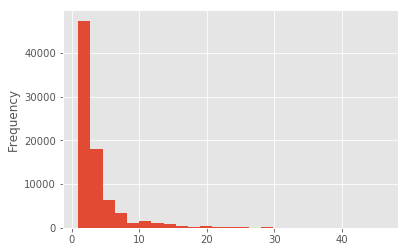

In [7]:
df["Answer Length"].plot.hist(bins = 25)
np.percentile(df["Answer Length"].as_matrix(), [i*10 for i in range(11)])

array([  22.,   81.,   97.,  106.,  116.,  126.,  139.,  154.,  175.,
        211.,  766.])

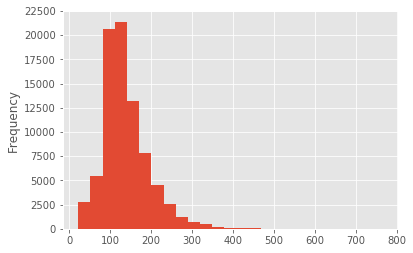

In [8]:
df["Context Length"].plot.hist(bins = 25)
np.percentile(df["Context Length"].as_matrix(), [i*10 for i in range(11)])

array([  1.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  16.,  60.])

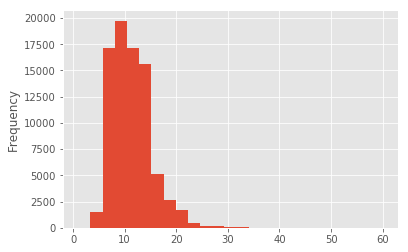

In [9]:
df["Question Length"].plot.hist(bins = 25)
np.percentile(df["Question Length"].as_matrix(), [i*10 for i in range(11)])

In [10]:
rev_vocab = ["afsad", "asdsd", "asfasd"]
[(x, y) for (y, x) in enumerate(rev_vocab)]

[('afsad', 0), ('asdsd', 1), ('asfasd', 2)]

## Read in word matrix

In [11]:
# Load the 100 dimension word embeddings
word_matrix = np.load("data/squad/glove.trimmed.100.npz")["glove"]

In [12]:
def read_id_files(file_path):
    data = []
    with open(file_path) as f:
        for i, line in enumerate(f):
            l = line.split()
            l = [int(j) for j in l]
            data.append(l)
    return(np.array(data))
# def read_data(file_path):

In [56]:
N_DIMS = 100
def pad_sequences(data, max_context_length, max_question_length):
    contexts = []
    contexts_masks = []
    questions = []
    questions_masks = []

    # Use this zero vector when padding sequences.
    zero = 0

    for context, question in data:
        ### YOUR CODE HERE (~4-6 lines)
        context = context[:max_context_length] 
        context_mask = [True for word in context]
        question = question[:max_question_length]
        question_mask = [True for word in question]
        
        while len(context) < max_context_length:
            context.append(zero)
            context_mask.append(False)
        while len(question) < max_question_length:
            question.append(zero)
            question_mask.append(False)
        
        contexts.append(context)
        contexts_masks.append(context_mask)
        questions.append(question)
        questions_masks.append(question_mask)
        
        ### END YOUR CODE ###
    return np.array(contexts), np.array(contexts_masks), np.array(questions), np.array(questions_masks)

In [64]:
class Config:
    embedding_size = 100
    max_context_length = 250
    max_question_length = 20
    batch_size = 32
    learning_rate = 1e-3
    
# Preprocessing the training/validation data
train_context = read_id_files("data/squad/train.ids.context")
train_question = read_id_files("data/squad/train.ids.question")
# # # train_answers = read_data("data/squad/train.answer")
# # # train_answer_span = read_data("data/squad/train.span")
train_inputs = zip(train_context, train_question)
train_context, train_context_mask, train_question, train_question_mask =\
pad_sequences(train_inputs, Config.max_context_length, Config.max_question_length)

val_context = read_id_files("data/squad/val.ids.context")
val_question = read_id_files("data/squad/val.ids.question")
# val_answer = read_data("data/squad/val.answer")
# val_answer_span = read_data("data/squad/val.span")
val_inputs = zip(val_context, val_question)
val_context, val_context_mask, val_question, val_question_mask = \
pad_sequences(val_inputs, Config.max_context_length, Config.max_question_length)

In [61]:
word_matrix[val_context[0:10]].shape

(10, 250, 100)

In [63]:
class Model:
    def __init__(self, pretrained_embeddings):
        self.pretrained_embeddings = pretrained_embeddings
    
    def add_placeholders(self):
        self.context_placeholder = tf.placeholder(tf.int32, shape = (None, max_context_length, embedding_size))
        self.question_placeholder = tf.placeholder(tf.int32, shape = (None, max_question_length, embedding_size))
        
    def create_feed_dict(self)

IndentationError: expected an indented block (<ipython-input-63-e3d1fffb9de7>, line 2)